In [1]:
import os
from torchvision.transforms import v2
import pandas as pd
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from utils import zeroPadFront, get_terminology
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib as mpl
from torch.utils.data import Dataset, DataLoader


In [2]:
class SPL_Terms:
    def __init__(self, path="./"):
        self.color = get_terminology(path + "/color.xml")
        self.color.set_index("code", inplace=True)
        self.shape = get_terminology(path + "/shape.xml")
        self.shape.set_index("code", inplace=True)

    def translateColorCode(self, spl_codes):
        if not spl_codes:
            return None
        elif isinstance(spl_codes, list):
            return [self.color.loc[c]["name"] if c in self.color.index else c for c in spl_codes]
        elif spl_codes in self.color.index:
            return self.color.loc[spl_codes]["name"]
        else:
            return spl_codes
    
    def translateShapeCode(self, spl_codes):
        if not spl_codes:
            return None
        elif isinstance(spl_codes, list):
            return [self.shape.loc[c]["name"] if c in self.shape.index else c for c in spl_codes]
        elif spl_codes in self.shape.index:
            return self.shape.loc[spl_codes]["name"]
        else:
            return spl_codes

spl_terms = SPL_Terms()

def getMarker(color):
    if not color:
        return {'marker':'.', 'markersize':10, 'color':'black'}
    elif len(color) == 1:
        return {'marker':'o', 'markersize':10, 'color':color[0], 'markeredgecolor':'black'}
    else:
        return {'marker':'o', 'markersize':10, 'fillstyle':'left', 'color':color[0], 'markerfacecoloralt':color[1], 'markeredgecolor':'black'}
    
def loadImages(paths):
    return np.stack(paths.map(Image.open))

def normalize(images):
    mean = np.mean(images, axis=(0,1,2))
    std = np.std(images, axis=(0,1,2))
    return (images-mean)/std

def encodeImages(image_paths, model):
    #load and normalize images
    images = normalize(np.stack(image_paths.map(Image.open)))

    #convert to tensor and change dimensions to (n,c,w,h)
    images = torch.Tensor(images).permute(dims=(0,3,1,2))

    with torch.no_grad():
        encodings=model(images)
    
    return encodings

format_ndc = lambda label_code, product_code: zeroPadFront(label_code, 5) + '-' + zeroPadFront(product_code, 4)


In [3]:
all_labels = pd.read_csv("./datasets/ePillID_data/all_labels.csv")
format_ndc = lambda label_code, product_code: zeroPadFront(label_code, 5) + '-' + zeroPadFront(product_code, 4)
codes = all_labels.apply(lambda x: format_ndc(x['label_code_id'], x['prod_code_id']), axis=1)
all_labels['NDC'] = codes

properties = pd.read_json("ePillId_properties.json")
properties["NDC"] = properties["NDC"].map(lambda x: format_ndc(x.split("-")[0], x.split("-")[1]))
properties.set_index("NDC", inplace=True)

all_labels_properties = all_labels.join(properties, on="NDC", how="left")
segmented_nih_pills = all_labels_properties[all_labels_properties["image_path"].str.startswith("segmented_nih_pills_224")]


In [4]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)

#peel off last layer
model.fc = torch.nn.Identity() 

In [13]:
class PillDataset(Dataset):
    def __init__(self, df, image_dir_path, transform=None, target_transform=None):
        self.df = df
        self.image_dir_path = image_dir_path
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = self.image_dir_path + (row["image_path"])
        image = Image.open(image_path)
        label = row["NDC"]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    

In [15]:
dir_path = "./datasets/ePillId_data/classification_data/"

image_paths = segmented_nih_pills["image_path"].map(lambda x: dir_path + x)
images = np.stack(image_paths.map(Image.open))

mean = np.mean(images, axis=(0,1,2))
std = np.std(images, axis=(0,1,2))

transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True), v2.Normalize(mean=mean, std=std)])
dataset = PillDataset(segmented_nih_pills, dir_path, transform=transform)
dl = DataLoader(dataset, batch_size=128)

In [18]:
model.eval()
encodings = []
batch_num = 0
for x,y in dl:
    print("Batch " + str(batch_num))
    with torch.no_grad():
        encodings.extend(model(x))
    batch_num += 1

Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60


In [44]:
encodings = torch.stack(encodings)
torch.save(encodings, "encodings.pt")

In [47]:
n, d = encodings.shape

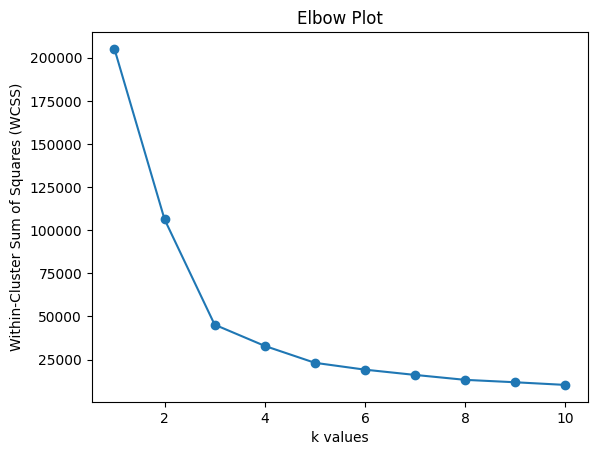

In [50]:
pca = PCA(2)
encodings2D = pca.fit_transform(encodings)
start_k = 1
max_k = 10
wcss=[]
for k in range(start_k, max_k+1):
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(encodings2D)
    center = kmeans.cluster_centers_
    wcss.append(kmeans.inertia_)
    n = len(labels)
    colors = list(mpl.colors.XKCD_COLORS.keys())[0:n]
    plt.scatter(encodings2D[:, 0], encodings2D[:, 1], c=list(map(lambda i: colors[i], labels)), s=10)
    plt.scatter(center[:, 0], center[:, 1], c='red', s=200, marker='X', label='Centroids')
    plt.title("k=" + str(k))
    plt.savefig("./cluster_plots" + "/k=" + str(k) + ".png")
    plt.close()

plt.plot(np.arange(start_k, max_k+1), wcss, marker="o")
plt.title("Elbow Plot")
plt.xlabel("k values")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.savefig("elbow_plot_dim=2.png")
plt.show()

In [84]:
g = []
k=6
kmeans = KMeans(n_clusters=k, random_state=0)
labels = kmeans.fit_predict(encodings)
center = kmeans.cluster_centers_
segmented_nih_pills['center_num'] = labels
for group in segmented_nih_pills.groupby('center_num'):
    g.append(group[1].groupby(['COLOR', 'SHAPE'])['label'].count().sort_values())
    print(g[-1][-3:])

COLOR   SHAPE 
C48331  C48348     199
C48330  C48348     309
C48325  C48348    1414
Name: label, dtype: int64
COLOR   SHAPE 
C48330  C48345     47
C48325  C48345    291
        C48336    304
Name: label, dtype: int64
COLOR   SHAPE 
C48331  C48336    56
C48332  C48348    56
C48333  C48336    94
Name: label, dtype: int64
COLOR   SHAPE 
C48328  C48336     75
C48330  C48336     79
C48325  C48336    120
Name: label, dtype: int64
COLOR   SHAPE 
C48331  C48345     57
C48330  C48345    124
C48325  C48345    434
Name: label, dtype: int64
COLOR   SHAPE 
C48328  C48348    57
C48330  C48348    61
C48332  C48348    84
Name: label, dtype: int64


/var/folders/sl/ml3mpv252c199n1s9b4d2y3r0000gq/T/ipykernel_77321/3542288406.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segmented_nih_pills['center_num'] = labels


/var/folders/sl/ml3mpv252c199n1s9b4d2y3r0000gq/T/ipykernel_77321/1417246275.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segmented_nih_pills['center_num'] = labels
/var/folders/sl/ml3mpv252c199n1s9b4d2y3r0000gq/T/ipykernel_77321/1417246275.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segmented_nih_pills['reduced_encoding'] = encodings2D.tolist()


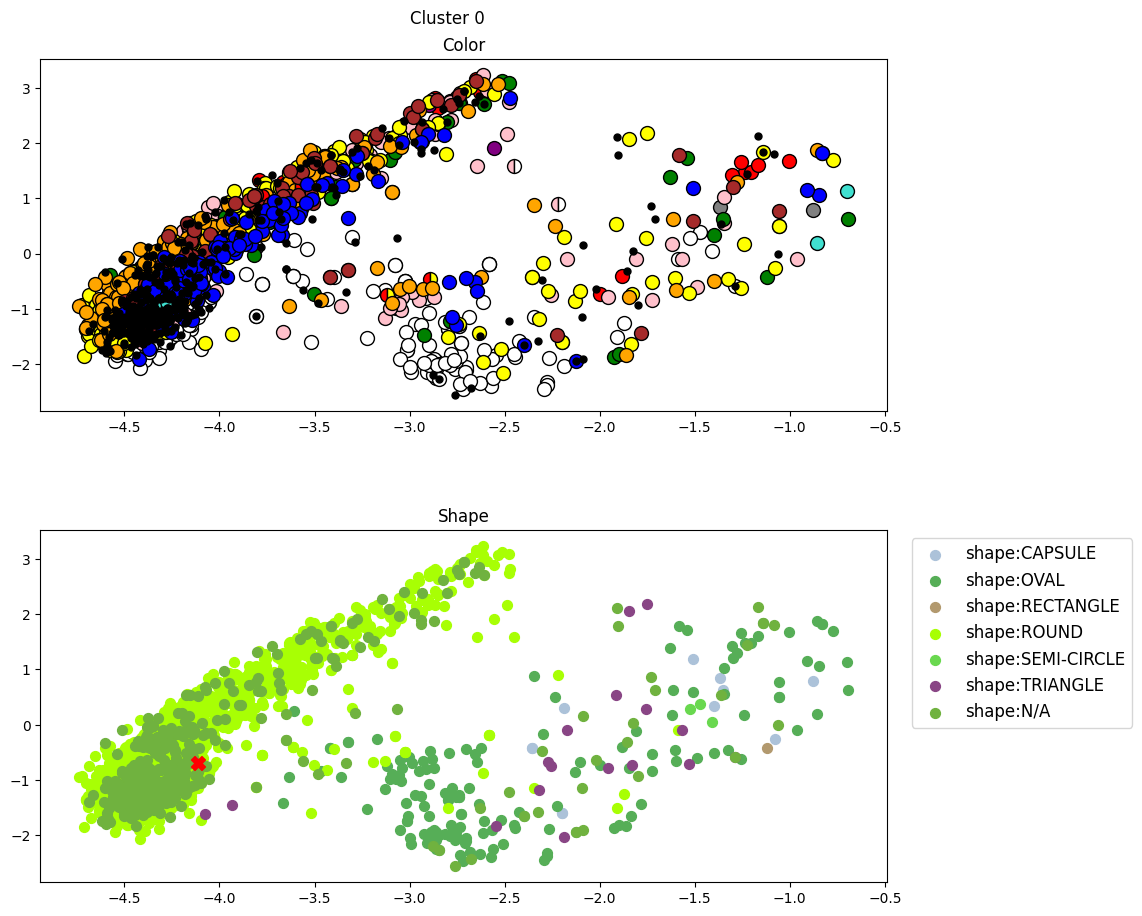

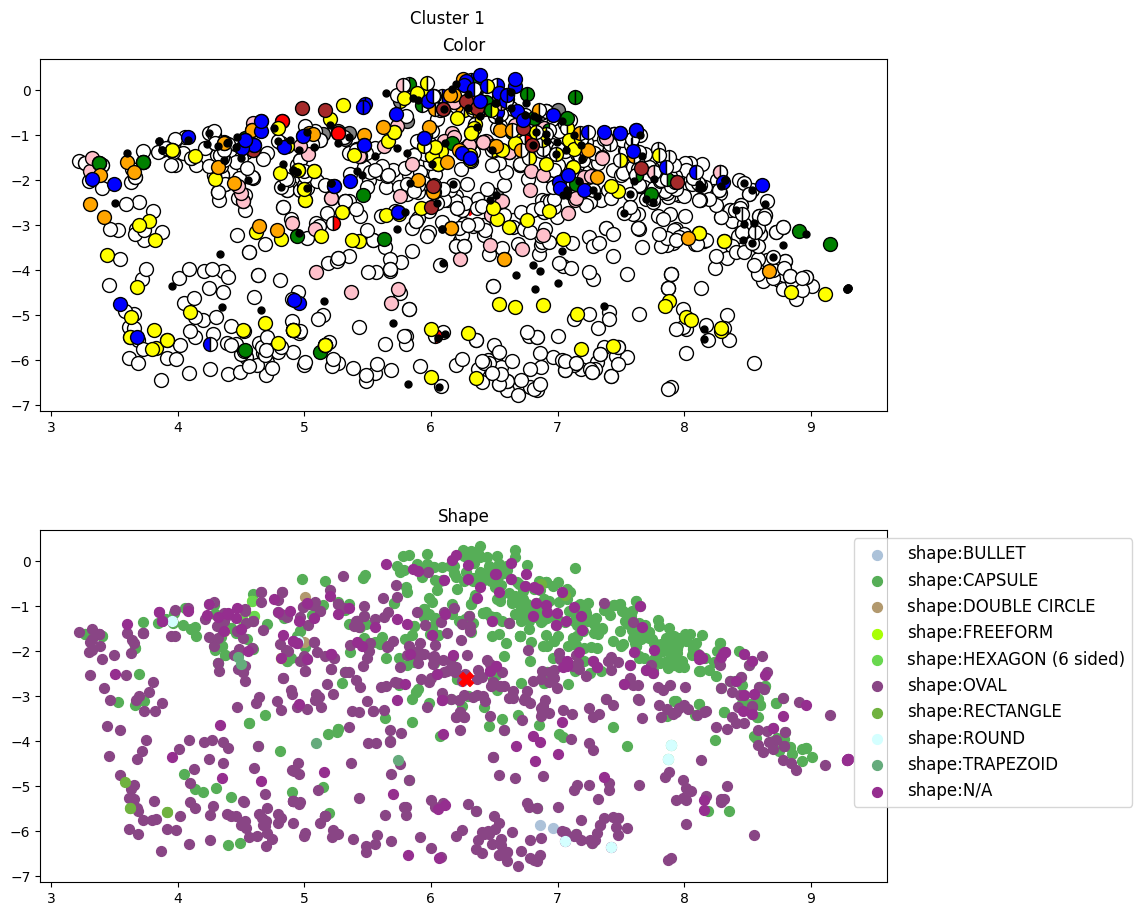

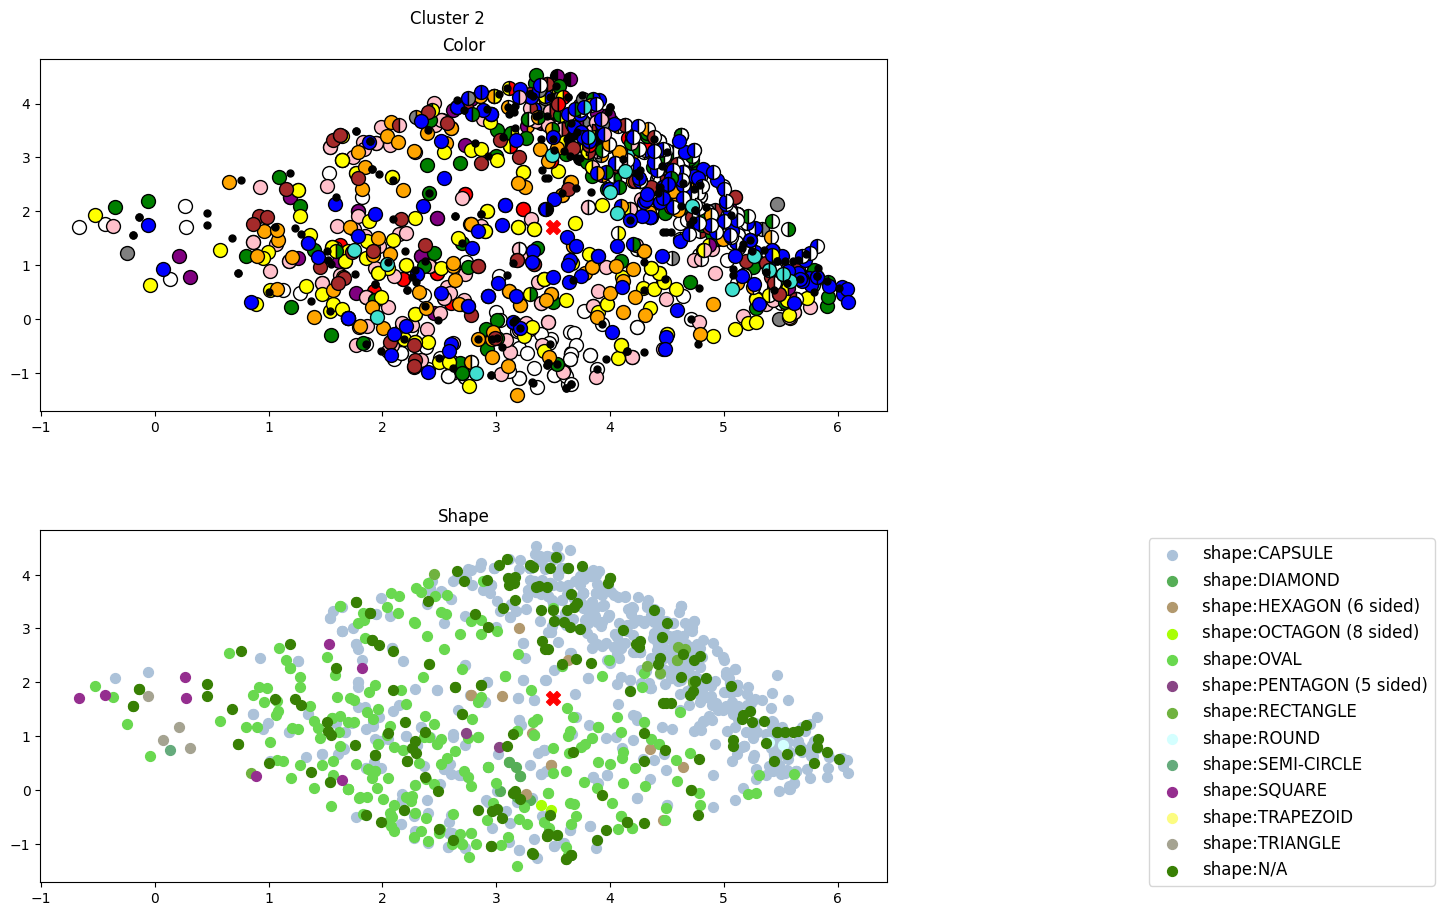

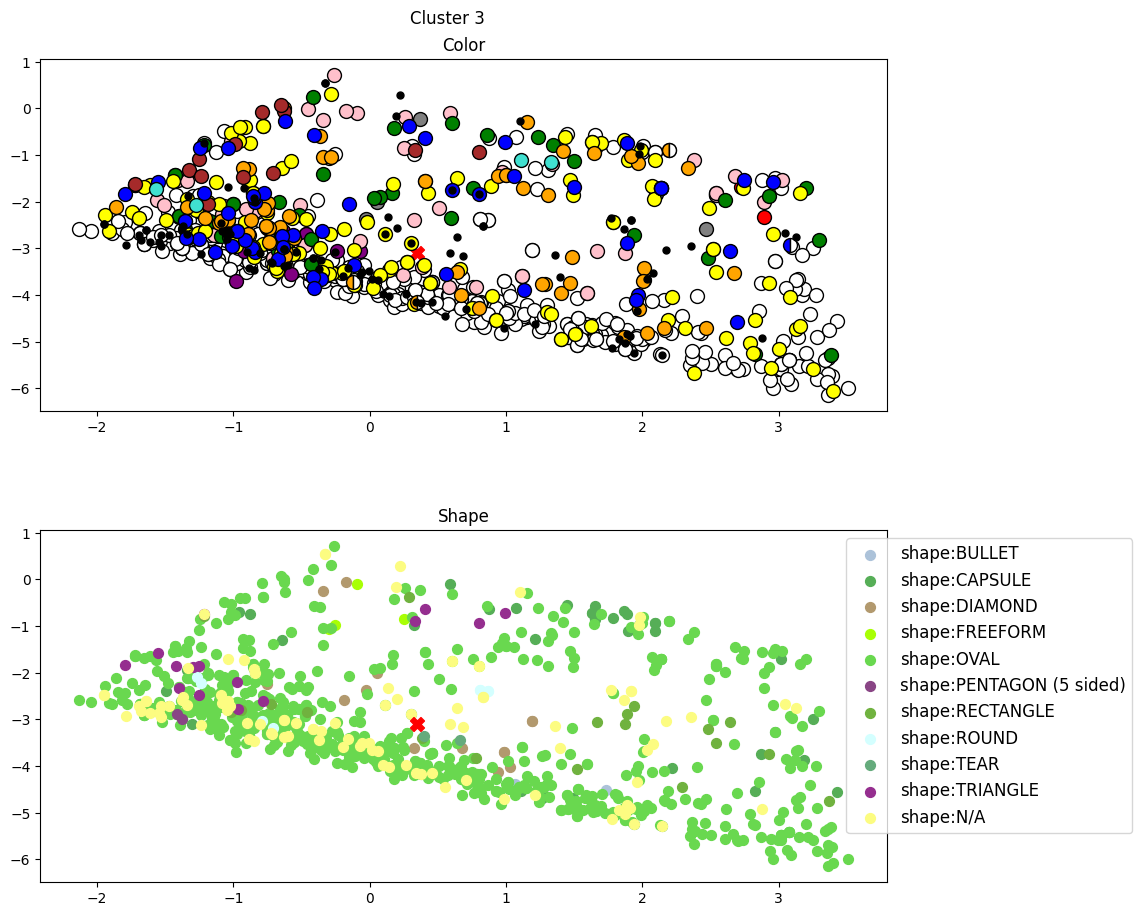

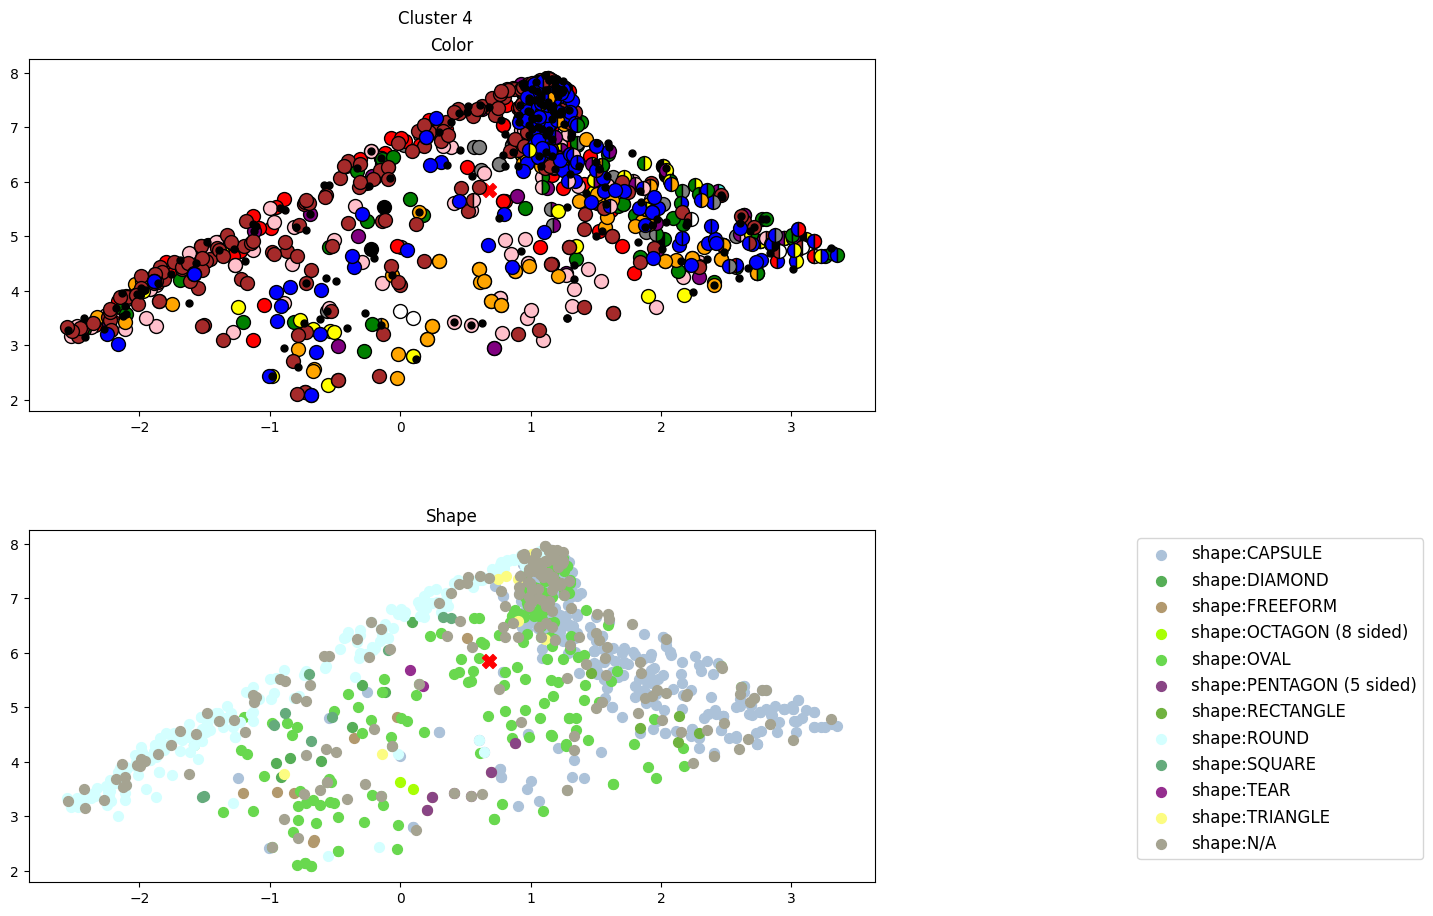

In [82]:
k=5
kmeans = KMeans(n_clusters=k, random_state=0)
labels = kmeans.fit_predict(encodings2D)
center = kmeans.cluster_centers_
segmented_nih_pills['center_num'] = labels
segmented_nih_pills['reduced_encoding'] = encodings2D.tolist()
os.makedirs("./k="+str(k), exist_ok=True)
for i,group in enumerate(segmented_nih_pills.groupby('center_num')):
    center_coord = center[group[0]]
    fig, ax = plt.subplots(2)
    fig.tight_layout(pad=2)
    fig.set_size_inches(10,10)
    plotByColor(group[1], ax[0], spl_terms)
    plotByShape(group[1], ax[1], spl_terms)
    ax[0].scatter(center_coord[0], center_coord[1], color='red', s=100, marker='X', label='Centroids')
    ax[1].scatter(center_coord[0], center_coord[1], color='red', s=100, marker='X', label='Centroids')

    fig.suptitle("Cluster " + str(i))
    fig.savefig("./k=" + str(k) +"/cluster=" + str(i))



In [83]:
g = []
for group in segmented_nih_pills.groupby('center_num'):
    g.append(group[1].groupby(['COLOR', 'SHAPE'])['label'].count().sort_values())
    print(g[-1][-3:])

COLOR   SHAPE 
C48331  C48348     239
C48330  C48348     366
C48325  C48348    1414
Name: label, dtype: int64
COLOR   SHAPE 
C48330  C48345     64
C48325  C48336    354
        C48345    367
Name: label, dtype: int64
COLOR   SHAPE 
C48330  C48336    70
C48333  C48336    71
C48328  C48336    72
Name: label, dtype: int64
COLOR   SHAPE 
C48331  C48345     56
C48330  C48345    111
C48325  C48345    398
Name: label, dtype: int64
COLOR   SHAPE 
C48332  C48345     55
C48333  C48336     93
C48332  C48348    106
Name: label, dtype: int64


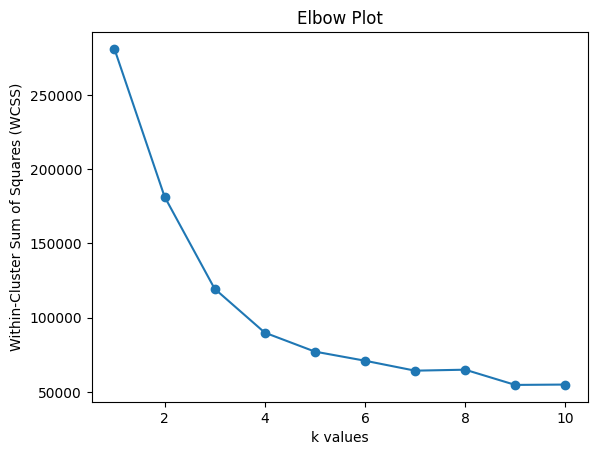

In [51]:
start_k = 1
max_k = 10
wcss=[]
for k in range(start_k, max_k+1):
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(encodings)
    center = kmeans.cluster_centers_
    wcss.append(kmeans.inertia_)
    n = len(labels)
    colors = list(mpl.colors.XKCD_COLORS.keys())[0:n]

plt.plot(np.arange(start_k, max_k+1), wcss, marker="o")
plt.title("Elbow Plot")
plt.xlabel("k values")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.savefig("elbow_plot_dim="+str(d)+".png")
plt.show()

In [66]:
rand_sample["image_path"] = rand_sample["image_path"].map(lambda x: dir_path + x)
rand_sample["encoding"] = encodeImages(rand_sample["image_path"], model).tolist()

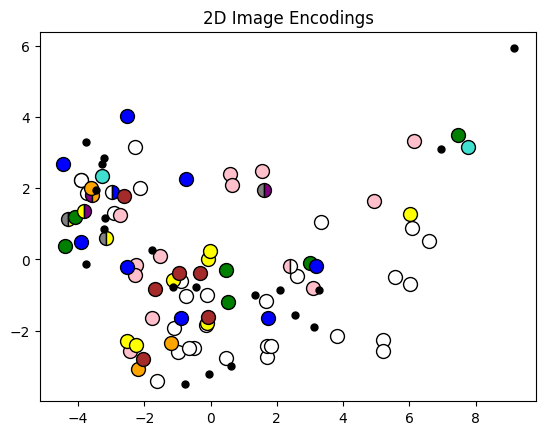

In [591]:
pca = PCA(2)
reduced_encodings = pca.fit_transform(np.stack(rand_sample["encoding"].values))
rand_sample["reduced_encoding"] = reduced_encodings.tolist()

for group in rand_sample.groupby("COLOR", dropna=False):
    if pd.notna(group[0]):
        color = spl_terms.translateColorCode(group[0].split(";"))
        marker_style = {'marker':'o', 'markersize':10, 'color':color[0], 'markeredgecolor':'black'}
        if len(color) > 1:
            marker_style['fillstyle']='left'
            marker_style['markerfacecoloralt']=color[1]
    else:
        marker_style= {'marker':'.', 'markersize':10, 'color':'black'}
    data = np.stack(group[1]["reduced_encoding"].values)
    plt.plot(data[:,0], data[:,1], linestyle="None", **marker_style)
plt.title("2D Image Encodings") 
plt.savefig("./2D_Image_Encodings_Color.png")
# plt.close()

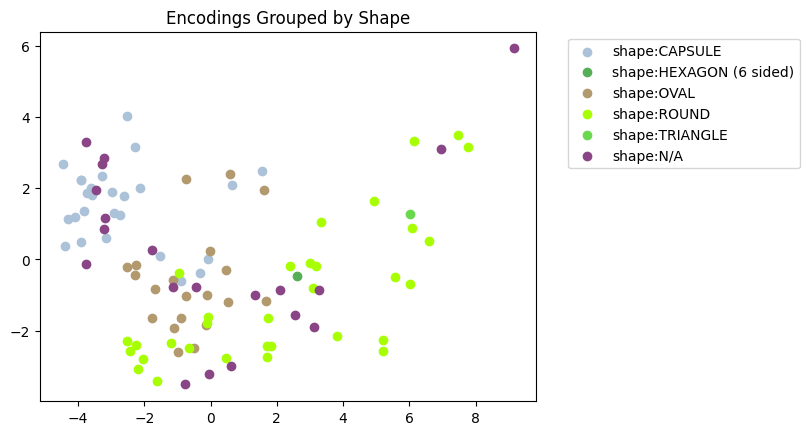

In [593]:
colors = list(mpl.colors.XKCD_COLORS.keys())
for i,group in enumerate(rand_sample.groupby("SHAPE", dropna=False)):
    if pd.notna(group[0]):
        shape = spl_terms.translateShapeCode(group[0])
    else:
        shape = "N/A"
    data = np.stack(group[1]["reduced_encoding"].values)
    plt.scatter(data[:,0], data[:,1], linestyle="None", c=colors[i], label="shape:"+shape)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title("Encodings Grouped by Shape")
plt.show()
# plt.savefig("./2D_Image_Encodings.png")


Text(0.5, 1.0, 'Encodings Grouped by Shape and Color')

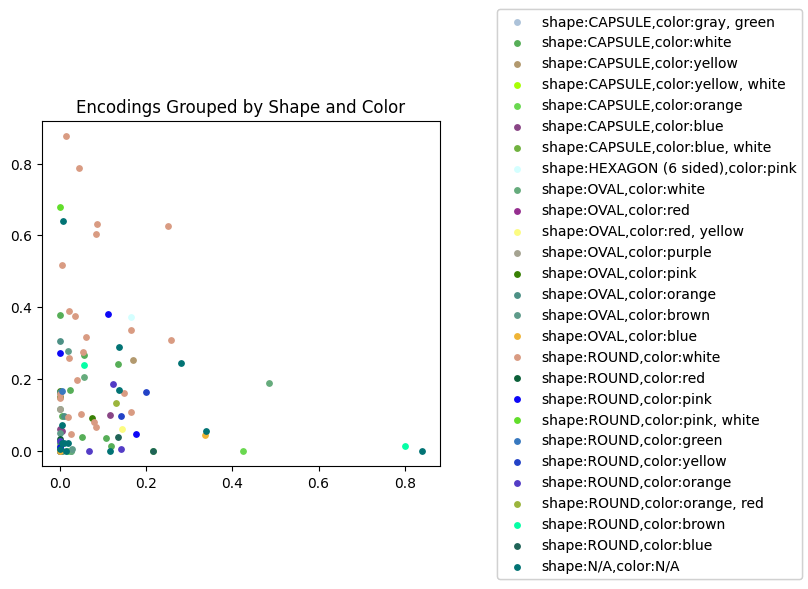

In [438]:
colors = list(mpl.colors.XKCD_COLORS.keys())
fig,ax = plt.subplot_mosaic([['left', 'right']], layout='constrained', figsize=(8, 4), width_ratios=[5,.5])
for i, group in enumerate(rand_sample.groupby(["SHAPE", "COLOR"], dropna=False)):
    if pd.notna(group[0][0]):
        shape = spl_terms.translateShapeCode(group[0][0])
    else:
        shape = "N/A"
    if pd.notna(group[0][1]):
        color = spl_terms.translateColorCode(group[0][1].split(";"))
        if (isinstance(color, list)):
            color = ", ".join(color)
    else:
        color = "N/A"
    label = "shape:" + shape + ",color:" + color
    data = np.stack(group[1]["encoding"].values)
    ax['left'].scatter(data[:, 0], data[:, 1], c=colors[i], s=15, label=label)
ax['right'].axis('off')
legend = fig.legend(loc="outside right")
ax['right'].add_artist(legend)
ax['left'].set_title("Encodings Grouped by Shape and Color")
# plt.savefig("./grouped_encodings_shape_color.png")
# plt.close()

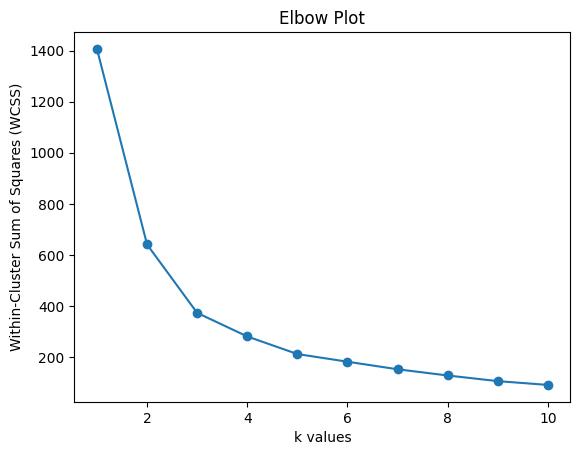

In [431]:
start_k = 1
max_k = 10
wcss=[]
encodings = np.stack(rand_sample["reduced_encoding"].values)
plt.close()
for k in range(start_k, max_k+1):
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(encodings)
    center = kmeans.cluster_centers_
    wcss.append(kmeans.inertia_)
    n = len(labels)
    colors = list(mpl.colors.XKCD_COLORS.keys())[0:n]
    plt.scatter(encodings[:, 0], encodings[:, 1], c=list(map(lambda i: colors[i], labels)), s=10)
    plt.scatter(center[:, 0], center[:, 1], c='red', s=200, marker='X', label='Centroids')
    plt.title("k=" + str(k))
    plt.savefig("./cluster_plots" + "/k=" + str(k) + ".png")
    plt.close()

plt.plot(np.arange(start_k, max_k+1), wcss, marker="o")
plt.title("Elbow Plot")
plt.xlabel("k values")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.savefig("elbow_plot.png")
plt.show()

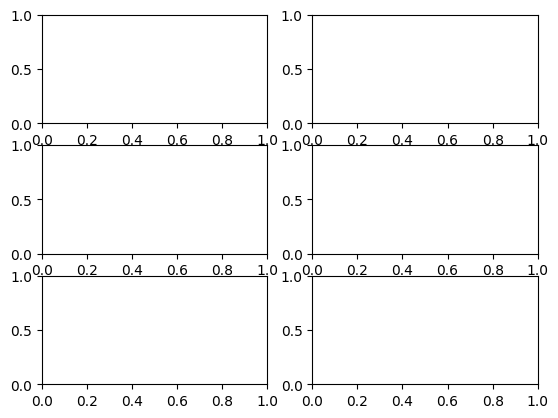

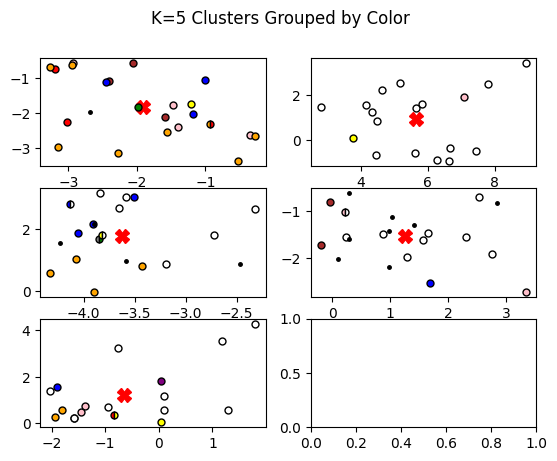

In [539]:
import math
kmeans = KMeans(n_clusters=5, random_state=0)
labels = kmeans.fit_predict(np.stack(rand_sample["reduced_encoding"].values))
center = kmeans.cluster_centers_
rand_sample['center_num'] = labels
nrows = math.ceil(math.sqrt(5))
ncols = math.floor(math.sqrt(5))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False)

for i,group in enumerate(rand_sample.groupby('center_num')):
    center_coord = center[group[0]]
    col = round(i%ncols)
    row = i//ncols
    ax[row][col].plot(center_coord[0], center_coord[1], color='red', markersize=10, marker='X', label='Centroids')
    for color_group in group[1].groupby("COLOR", dropna=False):
        if pd.notna(color_group[0]):
            color = spl_terms.translateColorCode(color_group[0].split(";"))
            marker_style = {'marker':'o', 'markersize':5, 'color':color[0], 'markeredgecolor':'black'}
            if len(color) > 1:
                marker_style['fillstyle']='left'
                marker_style['markerfacecoloralt']=color[1]
        else:
            marker_style= {'marker':'.', 'markersize':5, 'color':'black'}
        data = np.stack(color_group[1]["reduced_encodings"].values)
        ax[row][col].plot(data[:,0], data[:,1], linestyle="None", **marker_style)
fig.suptitle("K=5 Clusters Grouped by Color")
fig.savefig("K=5_Clusters_Color.png")



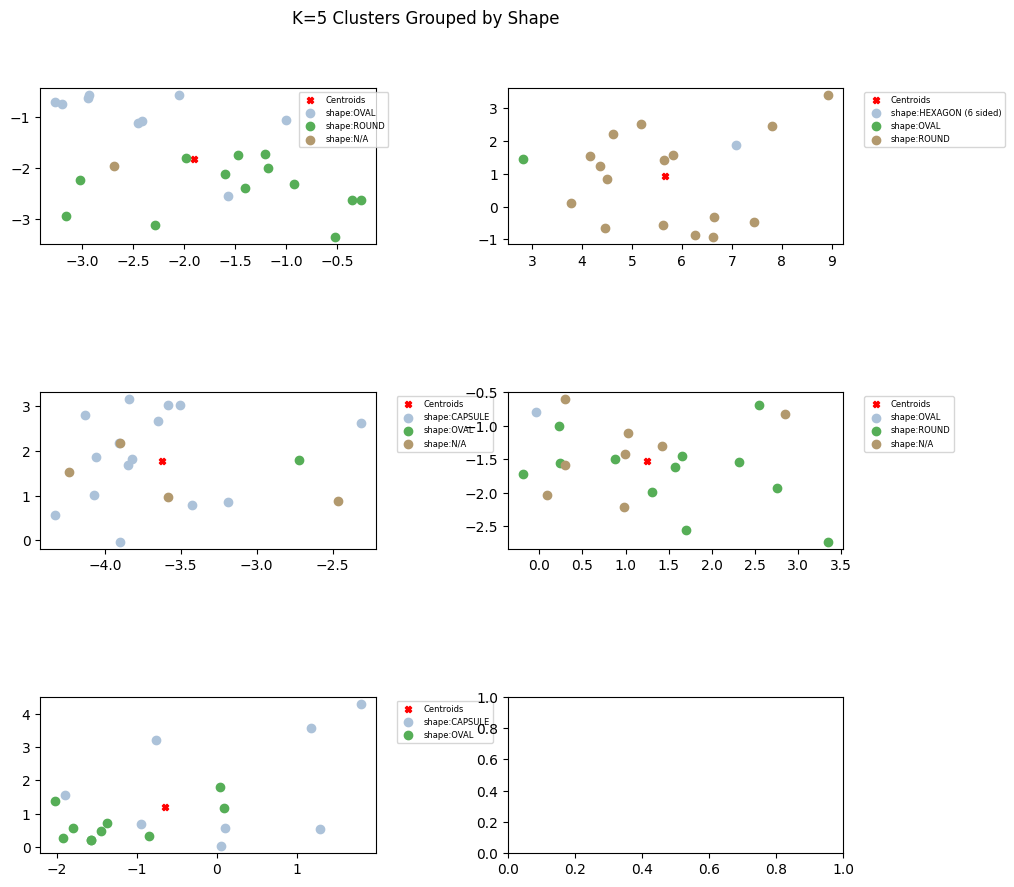

In [586]:
import math
colors = list(mpl.colors.XKCD_COLORS.keys())

kmeans = KMeans(n_clusters=5, random_state=0)
labels = kmeans.fit_predict(np.stack(rand_sample["reduced_encoding"].values))
center = kmeans.cluster_centers_
rand_sample['center_num'] = labels
nrows = math.ceil(math.sqrt(5))
ncols = math.floor(math.sqrt(5))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False)
fig.tight_layout(pad=3)
fig.set_size_inches(10,10)
for i,group in enumerate(rand_sample.groupby('center_num')):
    center_coord = center[group[0]]
    col = round(i%ncols)
    row = i//ncols
    ax[row][col].scatter(center_coord[0], center_coord[1], color='red', s=20, marker='X', label='Centroids')
    for idx, shape_group in enumerate(group[1].groupby("SHAPE", dropna=False)):
        if pd.notna(shape_group[0]):
            shape = spl_terms.translateShapeCode(shape_group[0])
        else:
            shape = "N/A"
        data = np.stack(shape_group[1]["reduced_encodings"].values)
        ax[row][col].scatter(data[:,0], data[:,1], c=colors[idx], label="shape:"+shape)
        ax[row][col].legend(bbox_to_anchor=(1.05, 1), fontsize=6)
fig.suptitle("K=5 Clusters Grouped by Shape")
fig.savefig("K=5_Clusters_Shape.png")


Text(0.5, 0.98, 'K=5 Clusters Grouped by Shape')

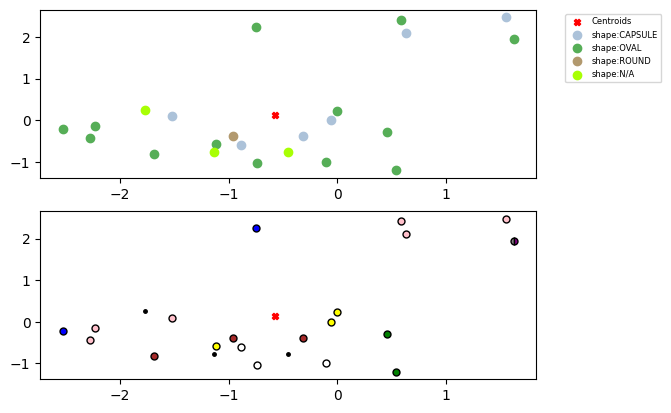

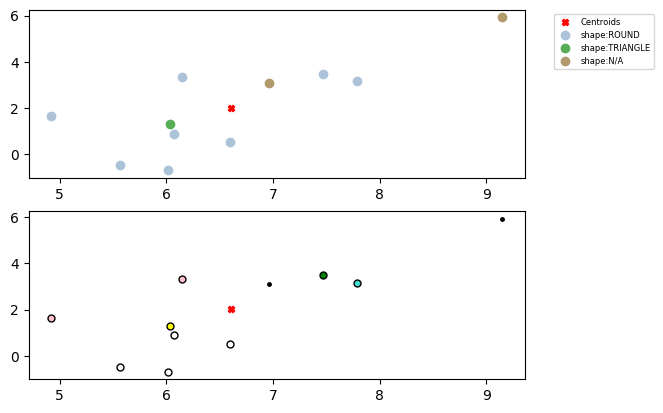

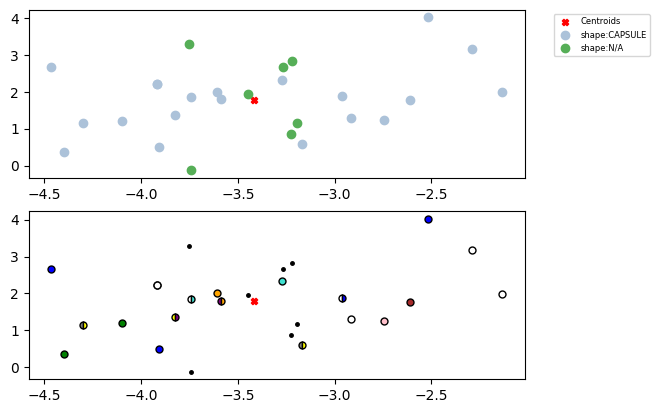

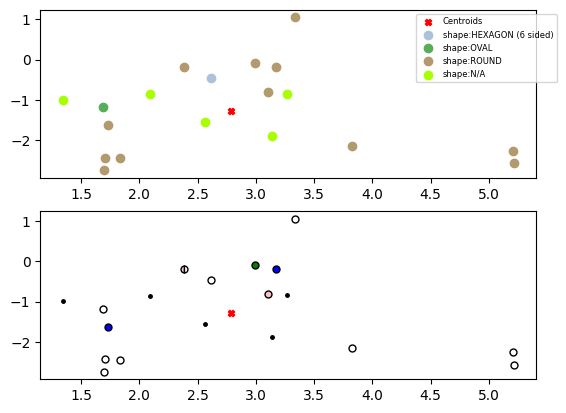

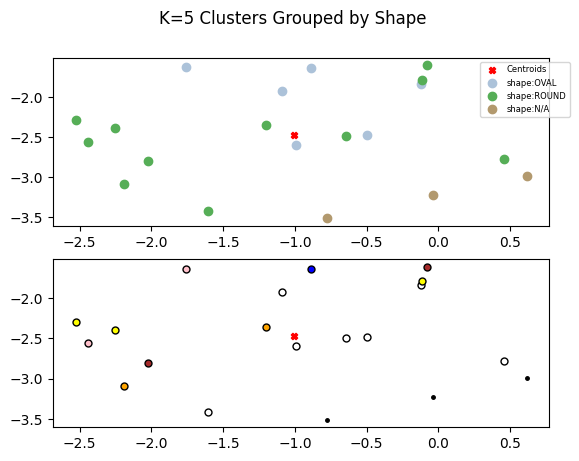

In [596]:
import math
colors = list(mpl.colors.XKCD_COLORS.keys())

kmeans = KMeans(n_clusters=5, random_state=0)
labels = kmeans.fit_predict(np.stack(rand_sample["reduced_encoding"].values))
center = kmeans.cluster_centers_
rand_sample['center_num'] = labels
nrows = math.ceil(math.sqrt(5))
ncols = math.floor(math.sqrt(5))
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False)
# fig.tight_layout(pad=3)
# fig.set_size_inches(10,10)
for i,group in enumerate(rand_sample.groupby('center_num')):
    center_coord = center[group[0]]
    col = round(i%ncols)
    row = i//ncols
    fig, ax = plt.subplots(2)
    ax[0].scatter(center_coord[0], center_coord[1], color='red', s=20, marker='X', label='Centroids')
    ax[1].scatter(center_coord[0], center_coord[1], color='red', s=20, marker='X', label='Centroids')
    for idx, shape_group in enumerate(group[1].groupby("SHAPE", dropna=False)):
        if pd.notna(shape_group[0]):
            shape = spl_terms.translateShapeCode(shape_group[0])
        else:
            shape = "N/A"
        data = np.stack(shape_group[1]["reduced_encoding"].values)
        ax[0].scatter(data[:,0], data[:,1], c=colors[idx], label="shape:"+shape)
        ax[0].legend(bbox_to_anchor=(1.05, 1), fontsize=6)
    for color_group in group[1].groupby("COLOR", dropna=False):
        if pd.notna(color_group[0]):
            color = spl_terms.translateColorCode(color_group[0].split(";"))
            marker_style = {'marker':'o', 'markersize':5, 'color':color[0], 'markeredgecolor':'black'}
            if len(color) > 1:
                marker_style['fillstyle']='left'
                marker_style['markerfacecoloralt']=color[1]
        else:
            marker_style= {'marker':'.', 'markersize':5, 'color':'black'}
        data = np.stack(color_group[1]["reduced_encoding"].values)
        ax[1].plot(data[:,0], data[:,1], linestyle="None", **marker_style)
fig.suptitle("K=5 Clusters Grouped by Shape")
# fig.savefig("K=5_Clusters_Shape.png")


In [52]:
def plotByShape(df, ax, spl_terms, title="Shape"):
    colors = list(mpl.colors.XKCD_COLORS.keys())
    for i, group in enumerate(df.groupby("SHAPE", dropna=False)):
        if pd.notna(group[0]):
            shape = spl_terms.translateShapeCode(group[0])
        else:
            shape = "N/A"
        data = np.stack(group[1]["reduced_encoding"].values)
        ax.scatter(data[:,0], data[:,1], c=colors[i], marker='o', label="shape:"+shape, s=50)
        ax.legend(bbox_to_anchor=(1.3, 1), fontsize=12)
        ax.set_title(title)

def plotByColor(df, ax, spl_terms, title="Color"):
    for group in df.groupby("COLOR", dropna=False):
        if pd.notna(group[0]):
            color = spl_terms.translateColorCode(group[0].split(";"))
            marker_style = {'marker':'o', 'markersize':10, 'color':color[0], 'markeredgecolor':'black'}
            if len(color) > 1:
                marker_style['fillstyle']='left'
                marker_style['markerfacecoloralt']=color[1]
        else:
            marker_style= {'marker':'.', 'markersize':10, 'color':'black'}
        data = np.stack(group[1]["reduced_encoding"].values)
        ax.set_title(title)
        ax.plot(data[:,0], data[:,1], linestyle="None", **marker_style)


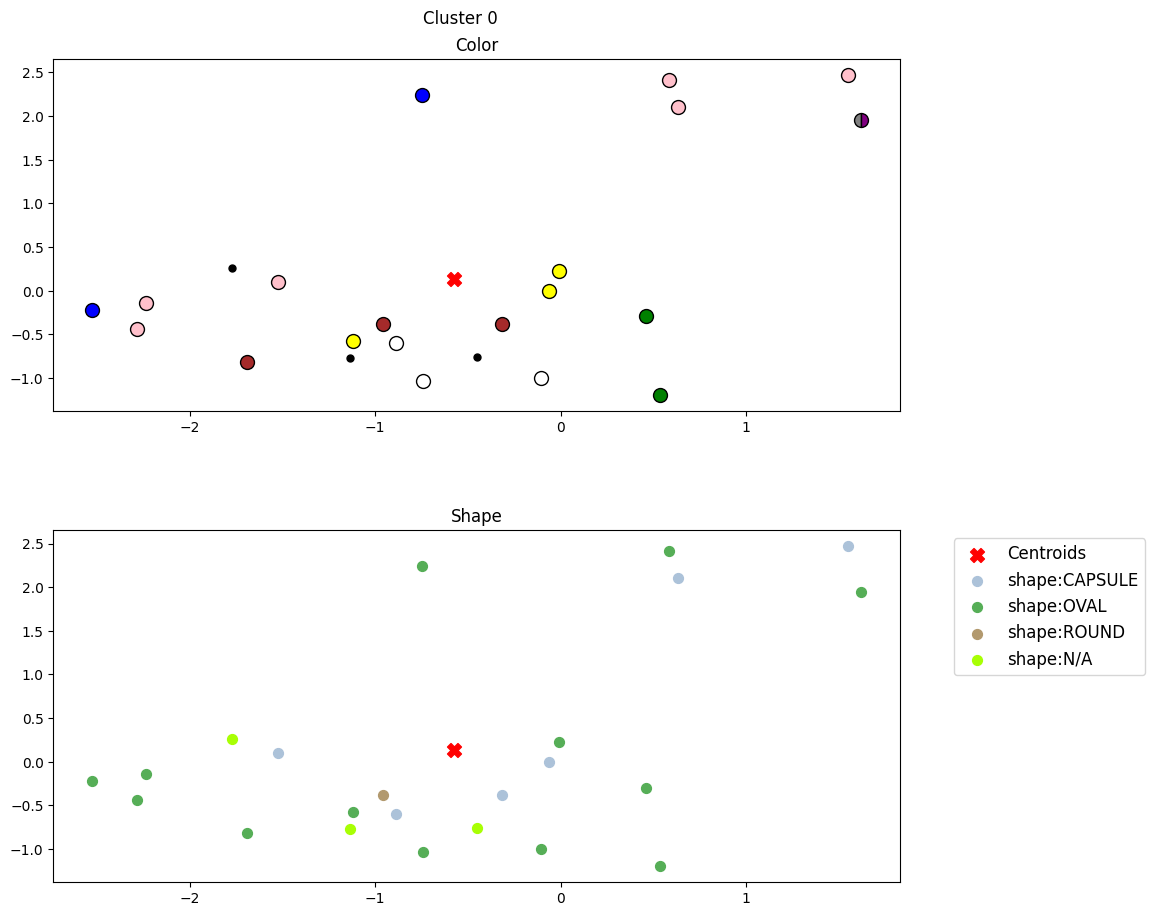

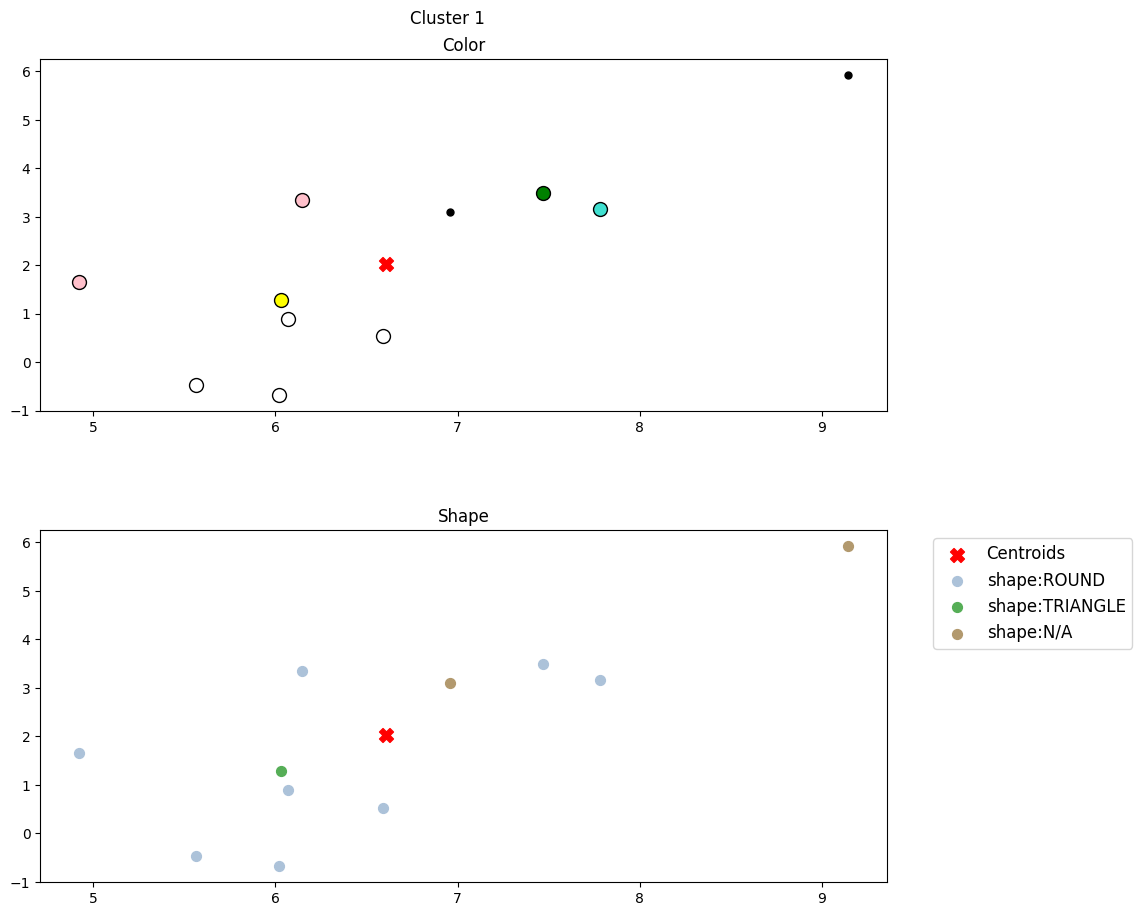

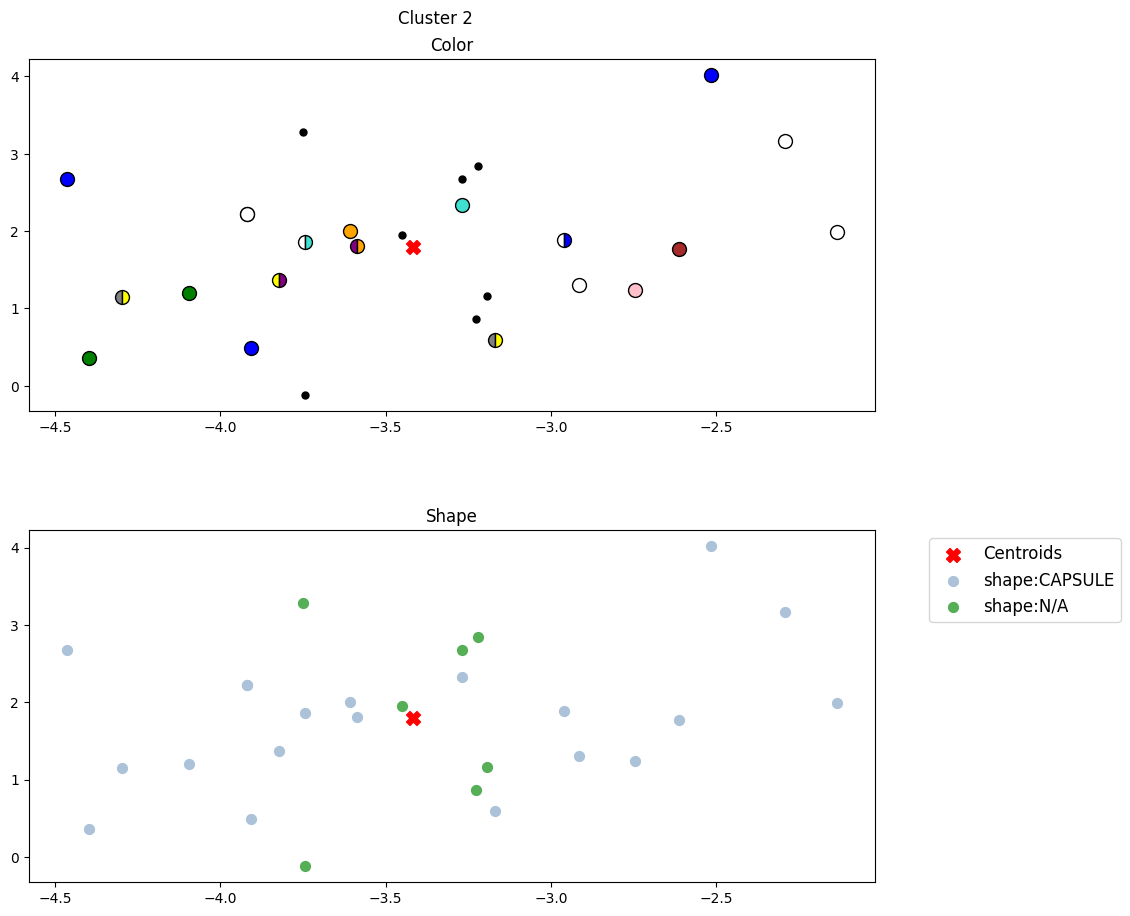

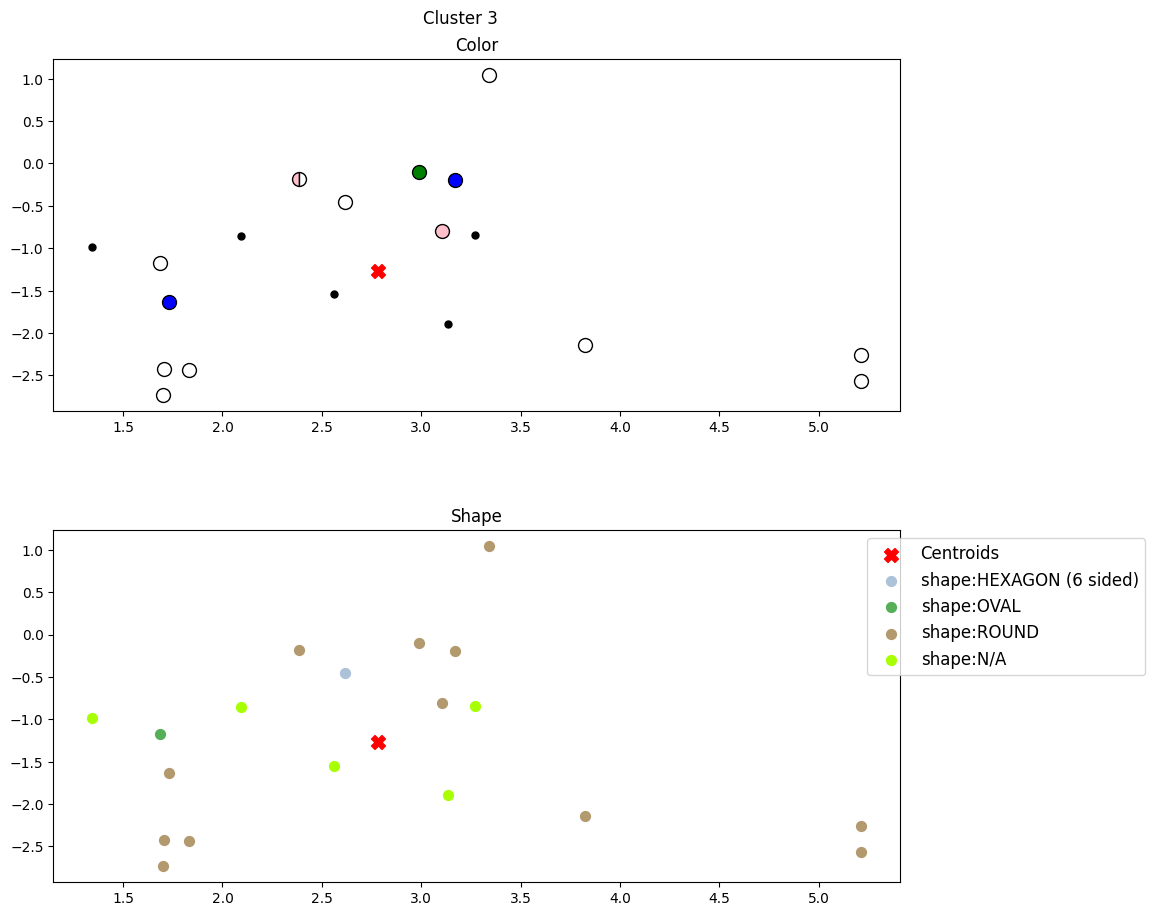

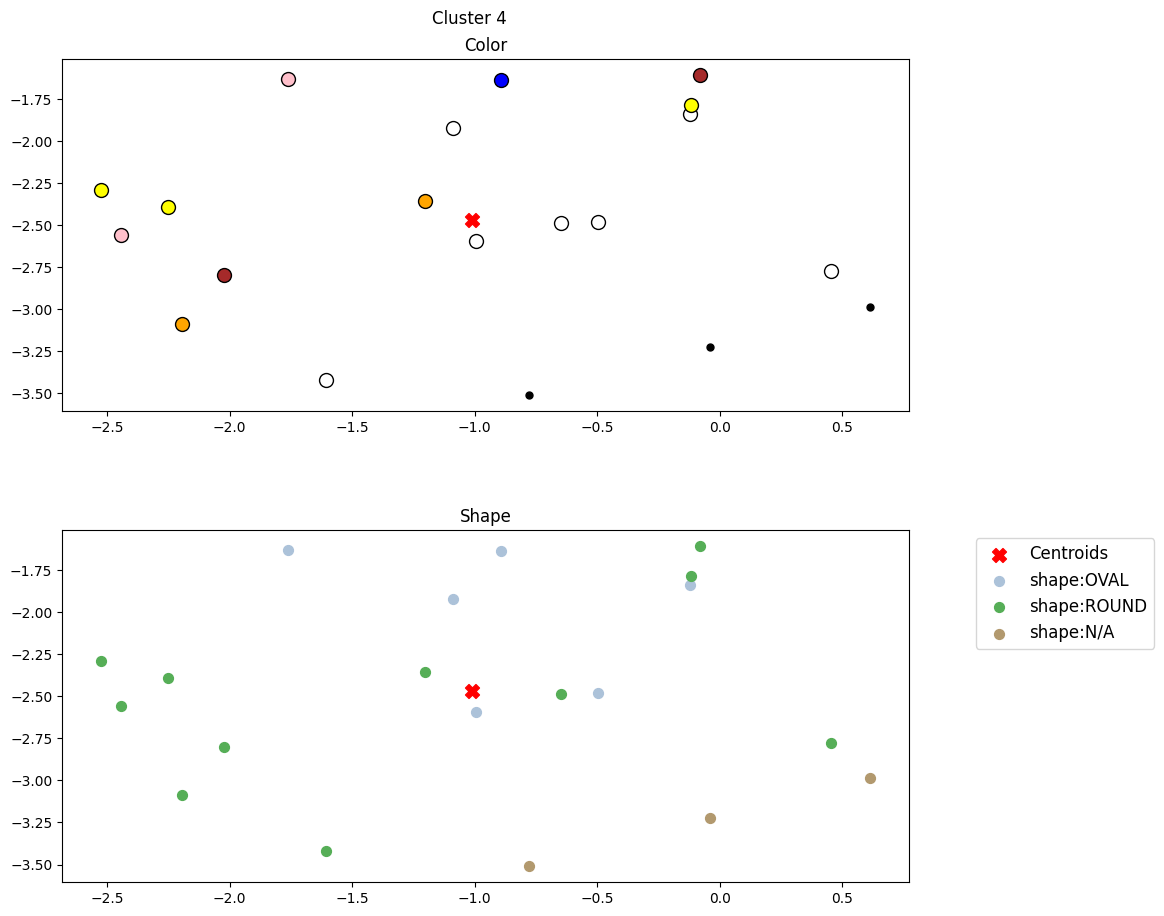

In [634]:
k=5
kmeans = KMeans(n_clusters=k, random_state=0)
labels = kmeans.fit_predict(np.stack(rand_sample["reduced_encoding"].values))
center = kmeans.cluster_centers_
rand_sample['center_num'] = labels
os.makedirs("./k="+str(k), exist_ok=True)
for i,group in enumerate(rand_sample.groupby('center_num')):
    center_coord = center[group[0]]
    fig, ax = plt.subplots(2)
    fig.tight_layout(pad=2)
    fig.set_size_inches(10,10)
    ax[0].scatter(center_coord[0], center_coord[1], color='red', s=100, marker='X', label='Centroids')
    ax[1].scatter(center_coord[0], center_coord[1], color='red', s=100, marker='X', label='Centroids')
    plotByColor(group[1], ax[0], spl_terms)
    plotByShape(group[1], ax[1], spl_terms)
    fig.suptitle("Cluster " + str(i))
    fig.savefig("./k=" + str(k) +"/cluster=" + str(i))

